In [65]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
import torch_geometric.transforms as T
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.manifold import TSNE
from torch.nn import functional as F

In [66]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = torch.tensor(np.where(out>0.5, 1, 0))  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask].unsqueeze(-1)  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

Opening the file, encode labels and find datas

In [82]:
df = pd.read_csv("/Users/giovanna/Desktop/Magistrale/SecondoAnno/AIBioInfo/Labs/LAB3_GNN/dataset_LUMINAL_A_B.csv")

#encoding labels
label_encoder = LabelEncoder()
df['l'] = label_encoder.fit_transform(df.l)

X = torch.tensor(scale(df.drop(labels=['l'], axis=1).values), dtype = torch.float32)
y = torch.tensor(df['l'].values, dtype=torch.long)

correlation = torch.from_numpy(np.where(torch.tensor(np.corrcoef(X))>0.0, 1, 0))
for i in range(correlation.shape[0]):
    correlation[i, i] = 0
    #make correlation a sparse matrix
edge_index = torch.nonzero(correlation).t()

In [83]:
print(edge_index.shape)
print(type(edge_index))

torch.Size([2, 4304])
<class 'torch.Tensor'>


## Creating Data object and do some transformation

In [84]:
data = Data(x=X, edge_index=edge_index, y=y)

In [85]:
transform = T.Compose([
    T.RemoveIsolatedNodes(),
])
data = transform(data)

In [86]:
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:int(0.8*data.num_nodes)] = 1
test_mask[int(0.8*data.num_nodes):] = 1
data.train_mask = train_mask
data.test_mask = test_mask

In [87]:
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[100, 1022], edge_index=[2, 4304], y=[100], train_mask=[100], test_mask=[100])
Number of nodes: 100
Number of edges: 4304
Average node degree: 43.04
Number of training nodes: 80
Training node label rate: 0.80
Has isolated nodes: False
Has self-loops: False
Is undirected: True


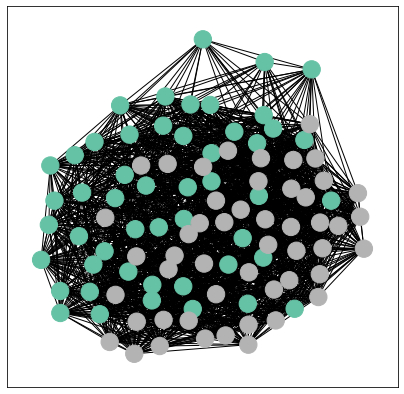

In [88]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## GNN model

In [93]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1022, 16)
  (conv2): GCNConv(16, 2)
)


## Now we create the embedding of the dataset

In [103]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

AttributeError: 'NoneType' object has no attribute 'split'

## Training of the model

In [96]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6948
Epoch: 002, Loss: 0.6206
Epoch: 003, Loss: 0.6031
Epoch: 004, Loss: 0.5234
Epoch: 005, Loss: 0.5301
Epoch: 006, Loss: 0.4837
Epoch: 007, Loss: 0.5079
Epoch: 008, Loss: 0.4973
Epoch: 009, Loss: 0.4816
Epoch: 010, Loss: 0.4758
Epoch: 011, Loss: 0.5056
Epoch: 012, Loss: 0.5220
Epoch: 013, Loss: 0.4773
Epoch: 014, Loss: 0.4734
Epoch: 015, Loss: 0.4970
Epoch: 016, Loss: 0.4655
Epoch: 017, Loss: 0.4807
Epoch: 018, Loss: 0.5556
Epoch: 019, Loss: 0.4498
Epoch: 020, Loss: 0.4756
Epoch: 021, Loss: 0.4841
Epoch: 022, Loss: 0.4680
Epoch: 023, Loss: 0.4432
Epoch: 024, Loss: 0.4526
Epoch: 025, Loss: 0.4325
Epoch: 026, Loss: 0.4512
Epoch: 027, Loss: 0.4605
Epoch: 028, Loss: 0.4557
Epoch: 029, Loss: 0.4242
Epoch: 030, Loss: 0.4206
Epoch: 031, Loss: 0.4377
Epoch: 032, Loss: 0.4233
Epoch: 033, Loss: 0.4054
Epoch: 034, Loss: 0.4393
Epoch: 035, Loss: 0.4105
Epoch: 036, Loss: 0.4149
Epoch: 037, Loss: 0.4199
Epoch: 038, Loss: 0.3910
Epoch: 039, Loss: 0.4073
Epoch: 040, Loss: 0.4168


In [97]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9000


In [98]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

AttributeError: 'NoneType' object has no attribute 'split'